In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt


2024-08-13 09:51:32.335373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 09:51:32.335425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 09:51:32.336775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 09:51:32.344939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-13 09:51:33.384043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


# Define the target image size
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Directories
data_dir = "/home/ubuntu/BTS/Breast_Cancer_Segmentation/Mass_Data"  # Replace with your path

# Load images and masks
def load_data(data_dir):
    images = []
    masks = []
    for label in ['Benign', 'Malignant']:
        image_dir = os.path.join(data_dir, label)
        for filename in os.listdir(image_dir):
            if filename.endswith('.png') and '_MASK' not in filename:
                # Load the image
                img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)
                mask_filename = filename.replace('.png', '_MASK.png')
                mask_path = os.path.join(image_dir, mask_filename)

                # Load the corresponding mask if it exists
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None and mask is not None:
                        images.append(img)
                        masks.append(mask)

    # Resize images and masks
    images = np.array([cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in images])
    masks = np.array([cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) for mask in masks])

    return np.array(images), np.array(masks)

images, masks = load_data(data_dir)

print(len(images))
print(len(images))


# Normalize images and masks
images = images / 255.0
masks = masks / 255.0
masks = masks[..., np.newaxis]  # Add a channel dimension to the masks

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing: Convert single channel to 3-channel by repeating the grayscale channel
X_train_3ch = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val_3ch = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_3ch = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

1961
1961


In [3]:


from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the DeepLabV3Plus model with adjusted Dropout Regularization
def DeepLabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Atrous Spatial Pyramid Pooling
    b4 = Conv2D(256, (1, 1), padding="same", use_bias=False)(base_model.output)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)
    b4 = Dropout(0.4)(b4)  # Reduced Dropout to 0.4 to retain more features

    # Decoder
    x = Conv2DTranspose(256, 3, strides=2, padding="same")(b4)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, base_model.get_layer("conv3_block12_concat").output])
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)  # Reduced Dropout to 0.4 here as well
    x = Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = Conv2D(num_classes, 1, padding="same")(x)

    # Up-sample to match the input shape
    x = UpSampling2D(size=(4, 4))(x)

    # Final activation layer for binary segmentation
    x = Activation('sigmoid')(x)

    # Model Definition
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Re-initialize and compile the model
model = DeepLabV3Plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
# Lowered the learning rate to 1e-6 for finer updates

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training data
train_generator = datagen.flow(X_train_3ch, y_train, batch_size=16)

# Early Stopping, Learning Rate Scheduler, and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
# Added a learning rate scheduler that reduces the learning rate by half if the validation loss plateaus

# Train the model with data augmentation, early stopping, and learning rate scheduling
history = model.fit(
    train_generator,
    validation_data=(X_val_3ch, y_val),
    epochs=50,  # Increased number of epochs to allow for more training time
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Mean IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.title('Mean IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()

plt.show()


2024-08-13 09:51:58.985276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 09:51:59.038528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 09:51:59.038795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-08-13 09:52:31.445534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-13 09:52:35.179975: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-13 09:52:35.327636: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-13 09:52:35.397426: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 163.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-13 09:52:35.427949: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 163.00MiB with f

NotFoundError: Graph execution error:

Detected at node model/conv2_block1_2_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ubuntu/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_18796/4149796293.py", line 63, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model/conv2_block1_2_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ubuntu/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/ubuntu/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_18796/4149796293.py", line 63, in <module>

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16781824 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng2{k2=1,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 318767104 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2_block1_2_conv/Conv2D}}]]
	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_55]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16781824 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng2{k2=1,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 318767104 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2_block1_2_conv/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_44876]

In [ ]:
# Save the model
# model.save('path_to_save_model/DeepLabV3Plus_model')


10/10 [==============================] - 5s 378ms/step


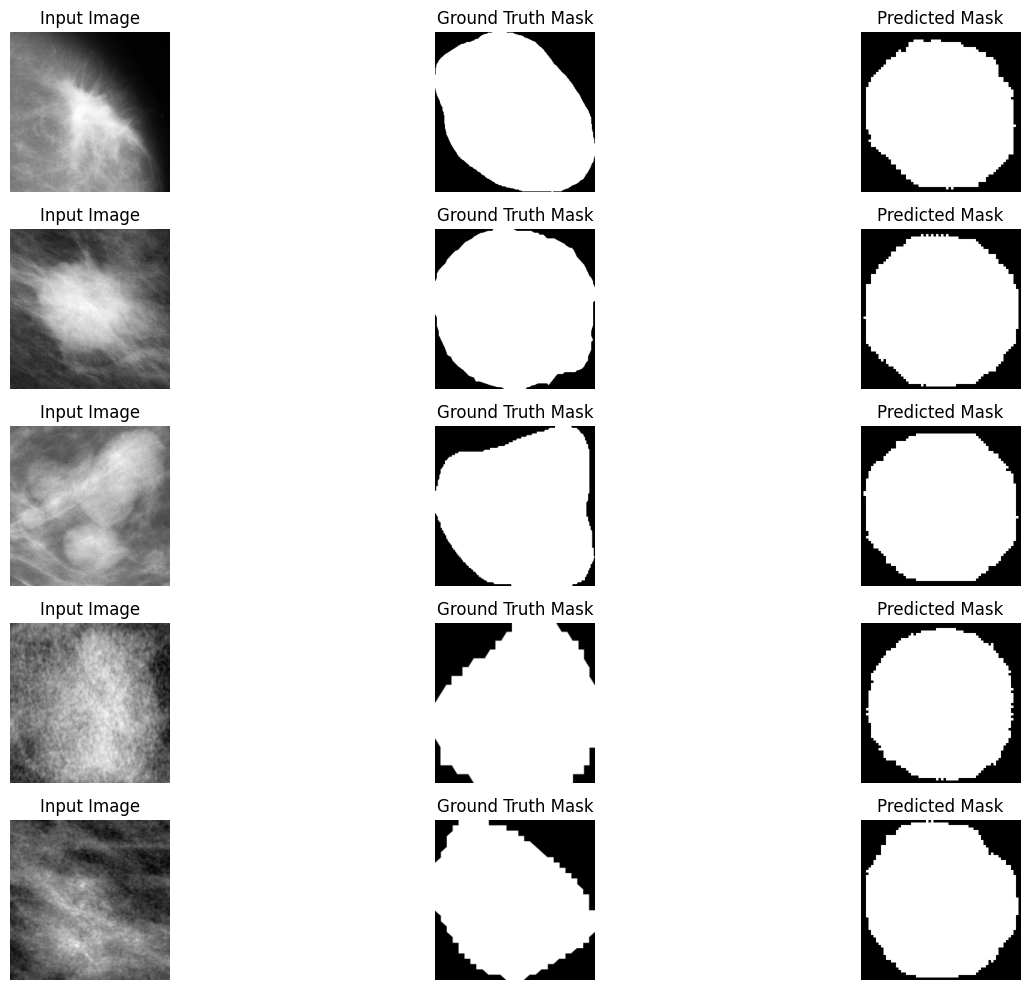

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_3ch)

# Threshold the predictions to create binary masks
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Visualize a few examples from the test set
num_examples = 5  # Number of examples to visualize

plt.figure(figsize=(15, 10))
for i in range(num_examples):
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(y_pred_thresholded[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()
